In this notebook we'll take a look at doing a sensitivity analysis by "functionizing" our models.  

In [1]:
import pandas as pd

profit = pd.read_excel('pizza-lp.xlsx', sheet_name='profit', index_col=0)
resource = pd.read_excel('pizza-lp.xlsx', sheet_name='resource', index_col=0)
rhs = pd.read_excel('pizza-lp.xlsx', sheet_name='rhs', index_col=0)

In [2]:
import pyomo_helpers as helpers

profit_dict = helpers.convert_1d_array_to_dict(profit)
resource_dict = helpers.convert_2d_array_to_dict(resource)
rhs_dict = helpers.convert_1d_array_to_dict(rhs)

# Pizza LP

In [4]:
import pyomo.environ as pe

model = pe.AbstractModel()

# Decision variables are defined by an index object rather than a list.
model.pizza_i = pe.RangeSet(1, resource.shape[1])    # decisions are four pizza types
model.resource_i = pe.RangeSet(1, resource.shape[0]) # there are 5 resources

# Decision variables definition
model.x = pe.Var(model.pizza_i, domain=pe.NonNegativeReals)

# Model parameters. 
model.profit_coef = pe.Param(model.pizza_i, initialize=profit_dict)
model.resource_coef = pe.Param(model.resource_i, model.pizza_i, initialize=resource_dict)
model.resource_rhs = pe.Param(model.resource_i, initialize=rhs_dict)

def objective_rule(model):
    return sum(model.profit_coef[p] * model.x[p] for p in model.pizza_i)
model.obj = pe.Objective(rule=objective_rule, sense=-1)

def resource_rule(model, r):
    return sum(model.resource_coef[r, p] * model.x[p] for p in model.pizza_i) <= model.resource_rhs[r]
model.resource_cons = pe.Constraint(model.resource_i, rule=resource_rule)

In [5]:
instance, obj, solution = helpers.solve(model, solver='glpk')


Problem: 
- Name: unknown
  Lower bound: 400.0
  Upper bound: 400.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 5
  Number of nonzeros: 17
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0600428581237793
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [6]:
solution.index = profit.index
solution

,x
pizza,
plain,0.0
meat,10.0
veggie,0.0
supreme,20.0


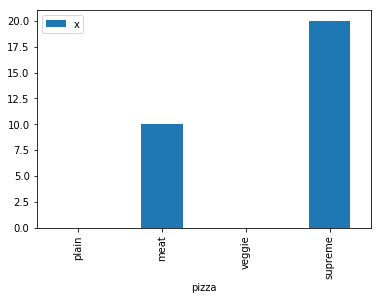

In [8]:
%matplotlib inline
_ = solution.plot(kind='bar')

## Sensitivity Analysis on Profit Coefficient

In [13]:
model = pe.AbstractModel()

# Decision variables are defined by an index object rather than a list.
model.pizza_i = pe.RangeSet(1, resource.shape[1])    # decisions are four pizza types
model.resource_i = pe.RangeSet(1, resource.shape[0]) # there are 5 resources

# Decision variables definition
model.x = pe.Var(model.pizza_i, domain=pe.NonNegativeReals)

# Model parameters. 
model.profit_coef = pe.Param(model.pizza_i, initialize=profit_dict, mutable=True)
model.resource_coef = pe.Param(model.resource_i, model.pizza_i, initialize=resource_dict)
model.resource_rhs = pe.Param(model.resource_i, initialize=rhs_dict)

def objective_rule(model):
    return sum(model.profit_coef[p] * model.x[p] for p in model.pizza_i)
model.obj = pe.Objective(rule=objective_rule, sense=-1)

def resource_rule(model, r):
    return sum(model.resource_coef[r, p] * model.x[p] for p in model.pizza_i) <= model.resource_rhs[r]
model.resource_cons = pe.Constraint(model.resource_i, rule=resource_rule)

In [14]:
plain_profits = list(range(8, 16))
obj_list, solution_list = [], []
instance = model.create_instance()
for p in plain_profits:
    instance.profit_coef[1] = p
    _, obj, solution = helpers.solve(instance)
    obj_list.append(obj)
    solution_list.append(solution)

    model; returning a clone of the current model instance.

Problem: 
- Name: unknown
  Lower bound: 400.0
  Upper bound: 400.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 5
  Number of nonzeros: 17
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0740516185760498
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

    model; returning a clone of the current model instance.

Problem: 
- Name: unknown
  Lower bound: 400.0
  Upper bound: 400.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 5
  Number of nonzeros: 17
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.05003547668457031
Sol

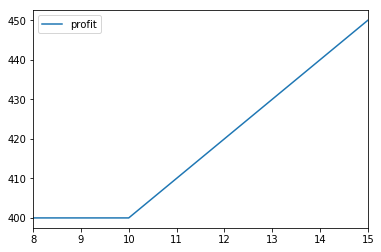

In [18]:
obj_df = pd.DataFrame(obj_list, index=plain_profits, columns=['profit'])
_ = obj_df.plot()

In [21]:
solution_df = pd.concat(solution_list, axis=1)
solution_df.index = profit.index
solution_df.columns = plain_profits
solution_df

,8,9,10,11,12,13,14,15
pizza,,,,,,,,
plain,0.0,0.0,10.0,10.0,10.0,10.0,10.0,30.0
meat,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
veggie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
supreme,20.0,20.0,20.0,20.0,20.0,20.0,20.0,0.0


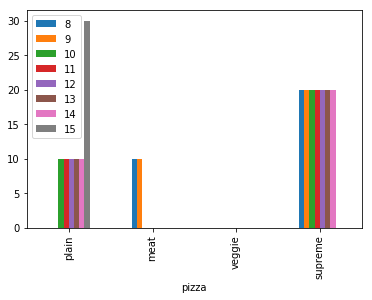

In [24]:
_ = solution_df.plot(kind='bar')